In [1]:
import torch
from torch import nn
from torch.utils import data
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython import display

## 训练误差和泛化误差

## 模型选择
---

## 欠拟合还是过拟合

## 多项式回归

In [2]:
## 生成数据集
max_degree = 20                     ## 多项式的最大阶数
n_train, n_test = 100, 100          ## 训练和测试数据集大小
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train+n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i+1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
"""example
a = np.array([1,2,3,4,5,6]).reshape(-1,1)
_pow = 2
_pows = np.array([1,2,3,4,5,6])
np.power(a, _pow), np.power(a, _pows)
"""
"""output
(array([[ 1],
        [ 4],
        [ 9],
        [16],
        [25],
        [36]]),
 array([[    1,     1,     1,     1,     1,     1],
        [    2,     4,     8,    16,    32,    64],
        [    3,     9,    27,    81,   243,   729],
        [    4,    16,    64,   256,  1024,  4096],
        [    5,    25,   125,   625,  3125, 15625],
        [    6,    36,   216,  1296,  7776, 46656]]))
"""

'output\n(array([[ 1],\n        [ 4],\n        [ 9],\n        [16],\n        [25],\n        [36]]),\n array([[    1,     1,     1,     1,     1,     1],\n        [    2,     4,     8,    16,    32,    64],\n        [    3,     9,    27,    81,   243,   729],\n        [    4,    16,    64,   256,  1024,  4096],\n        [    5,    25,   125,   625,  3125, 15625],\n        [    6,    36,   216,  1296,  7776, 46656]]))\n'

In [4]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]
]

In [5]:
class Accumulator:
    def __init__(self, n):
        self.data = [.0] * n
    def add(self, *args):
        self.data = [a+float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [.0] * len(self.data)
    def __getitem__(self, i):
        return self.data[i]

In [6]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = Accumulator(2)     ## 损失的总和、样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [7]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size=batch_size, shuffle=is_train)

In [8]:
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, xlim=None, ylim=None,
                xscale='linear', yscale='linear', legend=None,
                fmts=('-', 'm--', 'g-.', 'r:')):
        ## 增量地绘制多条线
        legend = [] if legend is None else legend
        self.fig, self.axes = plt.gcf(), plt.gca()
        self.config_axes = lambda: self.set_axes(xlabel, ylabel, xlim, ylim, xscale, yscale, legend) ## 使用lambda表达式捕获变量
        self.X, self.Y, self.fmts = None, None, fmts

    def set_axes(self, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        self.axes.set_xlabel(xlabel)
        self.axes.set_ylabel(ylabel)
        self.axes.set_xlim(xlim)
        self.axes.set_ylim(ylim)
        self.axes.set_xscale(xscale)
        self.axes.set_yscale(yscale)
        self.axes.legend(legend)
        self.axes.grid()

    def add(self, x, y):
        """向图表中添加多个数据点"""
        y = [y] if not hasattr(y, "__len__") else y
        x = [x] * len(y) if not hasattr(x, "__len__") else x
        self.X = [[] for _ in range(len(y))] if self.X is None else self.X
        self.Y = [[] for _ in range(len(y))] if self.Y is None else self.Y
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes.cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes.plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [9]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [10]:
def train_epoch(net, train_iter, loss, updater):
    """训练模型一个迭代周期"""
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        updater.zero_grad()
        l.mean().backward()
        updater.step()
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

In [11]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = Animator(xlabel='epoch', ylabel='loss', yscale='log', 
                        xlim=[1,num_epochs], ylim=[1e-3, 1e2], legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch+1) % 20 == 0:
            animator.add(epoch+1, (evaluate_loss(net, train_iter, loss),
                                   evaluate_loss(net, test_iter, loss)))
    print('weight: ', net[0].weight.data.numpy())

weight:  [[ 5.00247    1.2143757 -3.3863385  5.595954 ]]


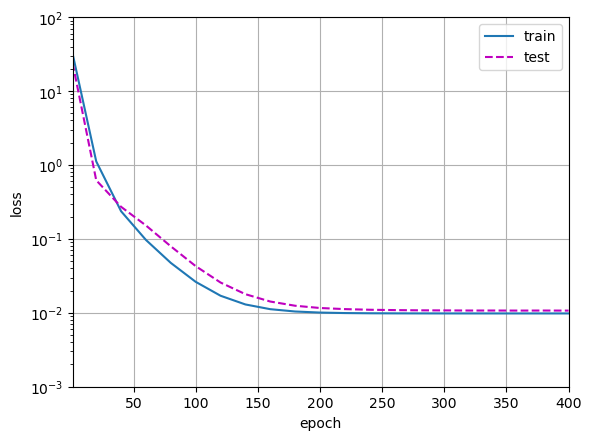

In [12]:
## 三阶多项式函数拟合
train(poly_features[:n_train, :4], poly_features[n_train:, :4], 
      labels[:n_train], labels[n_train:])

weight:  [[3.2563686 4.6016455]]


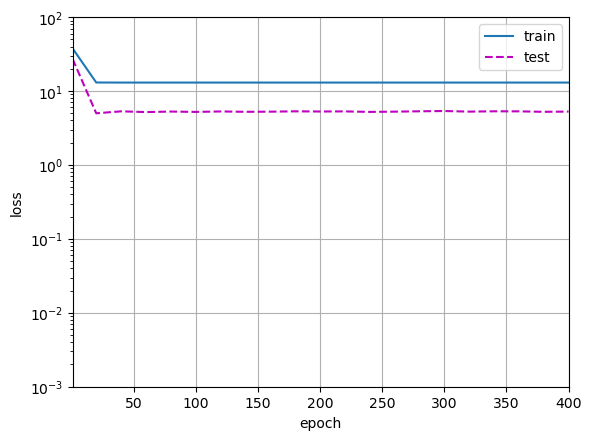

In [13]:
## 线性函数拟合
train(poly_features[:n_train, :2], poly_features[n_train:, :2], 
      labels[:n_train], labels[n_train:])

weight:  [[ 4.9246650e+00  1.3723116e+00 -3.0537229e+00  5.0372567e+00
  -7.4049324e-01  1.1334699e+00  9.7687662e-02  2.0283626e-01
  -1.5862126e-04 -1.4420094e-01 -5.3059213e-02  9.7116038e-02
   1.8279502e-01  1.3239759e-01  1.4801066e-01 -2.1008350e-01
  -9.9123910e-02 -1.7166527e-01  7.0099168e-02  3.6139868e-02]]


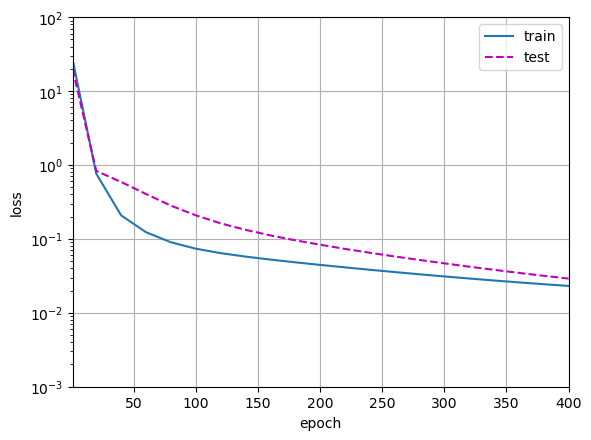

In [14]:
## 高阶多项式函数拟合
train(poly_features[:n_train, :], poly_features[n_train:, :], 
      labels[:n_train], labels[n_train:])

## Exercises

1. 这个多项式回归问题可以准确地解出吗？

2. 考虑多项式的模型选择
   - 绘制训练损失与模型复杂度（多项式的阶数）的关系图。观察到了什么？需要多少阶的多项式才能将训练损失减少到0?
   - 在这种情况下绘制测试的损失图
   - 生成同样的图，作为数据量的函数

3. 如果不对多项式特征$x^i$
进行标准化$(1/i!)$，会发生什么事情？能用其他方法解决这个问题吗？

4. 泛化误差可能为零吗？